In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630168 sha256=b2320d542d5d0928100facc2573fe9189b91a375754068d1ea17036245968d65
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
left_data = pd.read_csv('/content/drive/MyDrive/dataset/user_subset.csv')
left_data.head()

,Unnamed: 0,Usr,Song,Time
0,630,5a905f000fc1ff3df7ca807d57edb608863db05d,SOEBCBI12AF72A154F,5
1,658,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1
2,670,5a905f000fc1ff3df7ca807d57edb608863db05d,SOGJPMB12A8C13A9DB,1
3,919,5a905f000fc1ff3df7ca807d57edb608863db05d,SOUCKDH12A8C138FF5,2
4,1005,5a905f000fc1ff3df7ca807d57edb608863db05d,SOZOEYP12AB0188C9D,2


In [ ]:
right_data = pd.read_csv('/content/drive/MyDrive/dataset/meta_data_subset.csv')
right_data.head()

,Unnamed: 0,Song,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness
0,0,SOGSMXL12A81C23D88,Je Sais Que La Terre Est Plate,0.547953,148.74077,0,-9.636,1,124.059,Raphaël,0.386152
1,1,SOMBCOW12AAF3B229F,On Efface,0.475638,252.99546,1,-11.061,0,80.084,Julie Zenatti,0.434860
2,2,SOEYIHF12AB017B5F4,Howells Delight,NaN,78.02730,3,-24.140,1,54.874,The Baltimore Consort,0.000000
3,3,SODJYEC12A8C13D757,Martha Served,NaN,163.63057,7,-5.795,1,77.150,I Hate Sally,0.334520
4,4,SOGSOUE12A58A76443,Zip-A-Dee-Doo-Dah (Song of the South),NaN,199.99302,10,-16.477,1,120.382,Orlando Pops Orchestra,0.311616


In [ ]:
data = pd.merge(left_data, right_data, on=['Song'], how='left')
del left_data
del right_data
data.dropna(axis=0,how='any', inplace = True)  
data.head()

,Unnamed: 0_x,Usr,Song,Time,Unnamed: 0_y,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness
1,658,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1,2774,Hold On,0.693464,381.17832,7,-6.360,1,134.500,Hot Chip,0.535763
2,670,5a905f000fc1ff3df7ca807d57edb608863db05d,SOGJPMB12A8C13A9DB,1,1627,Unforgettable Season,0.890314,195.21261,10,-3.592,1,129.975,Cut Copy,0.536174
3,919,5a905f000fc1ff3df7ca807d57edb608863db05d,SOUCKDH12A8C138FF5,2,1126,Don't Panic,0.781932,139.12771,0,-8.501,1,122.291,Coldplay,0.916053
4,1005,5a905f000fc1ff3df7ca807d57edb608863db05d,SOZOEYP12AB0188C9D,2,9523,Plastic People,0.704239,393.84771,10,-9.857,1,124.043,Four Tet,0.474428
5,3271,732f88be38fae217f8ab7e24c20dd072436e3e40,SOFKTPP12A8C1385CA,1,2774,Hold On,0.693464,381.17832,7,-6.360,1,134.500,Hot Chip,0.535763


In [ ]:
# label编码
user_encoder = LabelEncoder()
data['Usr'] = user_encoder.fit_transform(data['Usr'].values)

song_encoder = LabelEncoder()
data['Song'] = song_encoder.fit_transform(data['Song'].values)


# 数据类型转换
data.astype({'Usr': 'int32', 'Song': 'int32', 'Time': 'int32'})

,Unnamed: 0_x,Usr,Song,Time,Unnamed: 0_y,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness
1,658,8020,561,1,2774,Hold On,0.693464,381.17832,7,-6.360,1,134.500,Hot Chip,0.535763
2,670,8020,660,1,1627,Unforgettable Season,0.890314,195.21261,10,-3.592,1,129.975,Cut Copy,0.536174
3,919,8020,1930,2,1126,Don't Panic,0.781932,139.12771,0,-8.501,1,122.291,Coldplay,0.916053
4,1005,8020,2394,2,9523,Plastic People,0.704239,393.84771,10,-9.857,1,124.043,Four Tet,0.474428
5,3271,10151,561,1,2774,Hold On,0.693464,381.17832,7,-6.360,1,134.500,Hot Chip,0.535763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151052,48373339,11585,1343,1,5209,Da Funk,0.862255,329.53424,5,-5.019,0,111.201,Daft Punk,1.021256
151053,48373364,11585,1591,1,7310,Swing Life Away,0.875511,200.12363,6,-7.679,1,184.591,Rise Against,0.625080
151054,48373382,11585,1809,1,54,15 Step,0.476435,237.21751,1,-7.057,1,188.910,Radiohead,0.683658
151055,48373405,11585,1930,2,1126,Don't Panic,0.781932,139.12771,0,-8.501,1,122.291,Coldplay,0.916053


In [ ]:
# 用户的歌曲播放总量的分布
# 字典user_playcounts记录每个用户的播放总量
user_playcounts = {}
for user, group in data.groupby('Usr'):
    user_playcounts[user] = group['Time'].sum()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


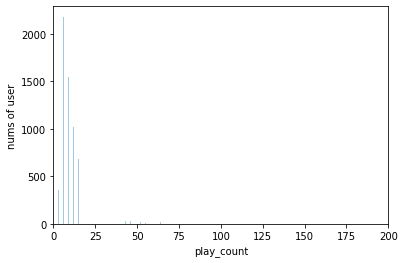

In [ ]:
# 作图
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

In [ ]:

temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 100]
temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 100]

print('歌曲播放量大于100的用户数量占总体用户数量的比例为', str(round(len(temp_user)/len(user_playcounts), 4)*100)+'%')
print('歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(user_playcounts.values())*100, 4))+'%')
print('歌曲播放量大于100的用户产生的数据占总体数据的比例为', str(round(len(data[data.Usr.isin(temp_user)])/len(data)*100, 4))+"%")

歌曲播放量大于100的用户数量占总体用户数量的比例为 0.19%
歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为 2.143%
歌曲播放量大于100的用户产生的数据占总体数据的比例为 0.2683%


In [ ]:

# # 过滤掉歌曲播放量少于100的用户的数据
# data = data[data.Usr.isin(temp_user)]

In [ ]:
# song_playcounts字典，记录每首歌的播放量
song_playcounts = {}
for song, group in data.groupby('Song'):
    song_playcounts[song] = group['Time'].sum() 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


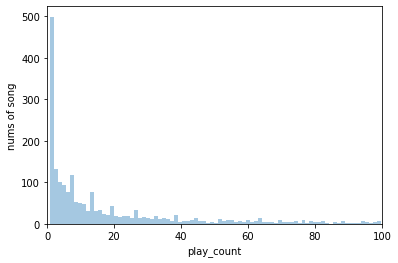

In [ ]:
# 作图
sns.distplot(list(song_playcounts.values()), bins=10000, kde=False)
plt.xlim(0, 100)
plt.xlabel('play_count')
plt.ylabel('nums of song')
plt.show()

In [ ]:
temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]

print('播放量大于20的歌曲数量占总体歌曲数量的比例为', str(round(len(temp_song)/len(song_playcounts), 4)*100)+'%')
print('播放量大于20的歌曲产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(song_playcounts.values())*100, 4))+'%')
print('播放量大于20的歌曲产生的数据占总体数据的比例为', str(round(len(data[data.Song.isin(temp_song)])/len(data)*100, 4))+"%")

播放量大于20的歌曲数量占总体歌曲数量的比例为 27.38%
播放量大于20的歌曲产生的播放总量占总体播放总量的比例为 93.5814%
播放量大于20的歌曲产生的数据占总体数据的比例为 92.8139%


In [ ]:
# # 过滤掉播放量小于50的歌曲
# data = data[data.Song.isin(temp_song)]

In [ ]:
user_averageScore = {}
for Usr, group in data.groupby('Usr'):
    user_averageScore[Usr] = group['Time'].mean()

In [ ]:
data['rating'] = data.apply(lambda x: np.log(2 + x.Time / user_averageScore[x.Usr]), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


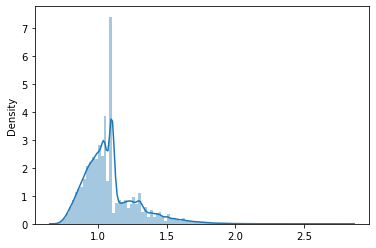

In [ ]:
sns.distplot(data['rating'].values, bins=100)
plt.show()

In [ ]:
user_item_rating = data[['Usr', 'Song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'Song': 'item'})

In [ ]:
#用户听过的歌曲集合
user_songs = {}
for user, group in user_item_rating.groupby('Usr'):
    user_songs[user] = group['item'].values.tolist()

# 歌曲集合
songs = user_item_rating['item'].unique().tolist()

In [ ]:
user_item_rating.head()

,Usr,item,rating
1,8020,561,0.980829
2,8020,660,0.980829
3,8020,1930,1.203973
4,8020,2394,1.203973
5,10151,561,1.049822


In [ ]:
# userCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=2)
# 构建模型
knn_usercf = KNNBasic(k=40, sim_options={'user_based': True})
# 训练数据集，并返回rmse误差
# knn_usercf.fit(raw_data)
print(type(raw_data))
for trainset, testset in kf.split(raw_data):
    print(type(trainset))
    knn_usercf.fit(trainset)
#     predictions = knn_usercf.test(testset)
#     accuracy.rmse(predictions, verbose=True)

<class 'surprise.dataset.DatasetAutoFolds'>
<class 'surprise.trainset.Trainset'>
Computing the msd similarity matrix...
Done computing similarity matrix.
<class 'surprise.trainset.Trainset'>
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
# userCF 推荐
def recommendation_basedonUserCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    
    return song_ids

recommendation_basedonUserCF(8021)

{320: 1.9409718674147307,
 470: 1.7730673362159026,
 697: 1.849329321049533,
 1745: 1.7462970951512977,
 1848: 1.7771606698069025}

In [ ]:
data.isnull()

,Unnamed: 0_x,Usr,Song,Time,Unnamed: 0_y,title,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness,rating
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151052,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
151053,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
151054,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
151055,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 复制原data数据
rank_data = data.copy()
# 去掉无用的title列
rank_data = rank_data.loc[ : , ~rank_data.columns.str.contains("^Unnamed")]

rank_data.drop(["title", "Time"], axis = 1, inplace=True)

artist_encoder = LabelEncoder()
rank_data['artist'] = artist_encoder.fit_transform(rank_data['artist'].values)

rank_data['rating'] = rank_data['rating'].apply(lambda x: 0 if x < 0.7 else 1)

rank_data.head()

,Usr,Song,song_hotness,duration,key,loudness,mode,tempo,artist,artist_hotness,rating
1,8020,561,0.693464,381.17832,7,-6.360,1,134.500,563,0.535763,1
2,8020,660,0.890314,195.21261,10,-3.592,1,129.975,287,0.536174,1
3,8020,1930,0.781932,139.12771,0,-8.501,1,122.291,267,0.916053,1
4,8020,2394,0.704239,393.84771,10,-9.857,1,124.043,470,0.474428,1
5,10151,561,0.693464,381.17832,7,-6.360,1,134.500,563,0.535763,1


In [ ]:
rank_data.shape

(133813, 11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rank_data.iloc[:, :-1].values, rank_data.iloc[:, -1].values, test_size=0.2)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1] , 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
type(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
import tensorflow as tf

In [ ]:
model = keras.Sequential([keras.layers.Flatten(input_shape = (10, 1)),
                keras.layers.Dense(128,activation = tf.nn.relu),     
                keras.layers.Dense(64,activation = tf.nn.relu), 
                keras.layers.Dense(1),                 
                keras.layers.Dense(1,activation = tf.nn.sigmoid)])
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics =['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=1, batch_size=64,
validation_data=(X_test, y_test), verbose=2)
model.summary() # 查看你的神经网络的架构和参数量等信息

1673/1673 - 5s - loss: 1.3241e-06 - accuracy: 1.0000 - val_loss: 6.1211e-11 - val_accuracy: 1.0000 - 5s/epoch - 3ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               1408      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
Total params: 9,731
Trainable params: 9,731
Non-trainable params:

In [ ]:
from keras.models import Model
# 推荐
def recommendation(userID):
    # 召回50首歌
    recall = recommendation_basedonUserCF(userID, 50)
    
    # 根据召回的歌曲信息，写出特征向量
    feature = rank_data[rank_data['Song'].isin(list(recall.keys()))]
    feature['Usr'] = userID
    feature.drop("rating", axis = 1, inplace = True)
    # feature = feature.groupby(["Song"]).mean()
    feature.drop_duplicates(inplace = True)
    feature.sort_values(by="Song" , ascending=True, inplace = True)
    recall_list = list(recall.keys())
    recall_list.sort()
    feature = feature.to_numpy().reshape(feature.shape[0], feature.shape[1], 1)
    
    
    # 用gbdt+lr计算权重
    
    middle = Model(inputs=model.input,outputs=model.get_layer('dense_5').output)
    weights = middle.predict(feature)
    weights = weights / weights.max()
    # weights = model.predict(feature)

    print("weights ", weights)
    print('排序权重计算完毕！')

    
    # 计算最终得分
    score = {}
    i = 0
    for song in recall_list:
        score[song] = recall[song] * weights[i]
        i += 1
    
    # 选出排名前5的歌曲id
    print(score)
    song_ids = dict(sorted(score.items(), key=lambda x: x[1], reverse=True)[: 5])
    
    print('最终推荐列表为')
    
    return song_ids
    # return 0

# 测试
recommendation(8021)

weights  [[0.8237507 ]
 [0.8369827 ]
 [0.8279608 ]
 [0.83687055]
 [0.8443229 ]
 [0.84723955]
 [0.83240485]
 [0.8520636 ]
 [0.8454216 ]
 [0.856437  ]
 [0.8573271 ]
 [0.87444085]
 [0.88083404]
 [0.86277574]
 [0.86679626]
 [0.8591629 ]
 [0.88039297]
 [0.85457385]
 [0.87250435]
 [0.8801872 ]
 [0.8713008 ]
 [0.87894875]
 [0.86931777]
 [0.890707  ]
 [0.90459305]
 [0.889948  ]
 [0.88135105]
 [0.8741767 ]
 [0.86898494]
 [0.8892553 ]
 [0.904827  ]
 [0.90550923]
 [0.9104771 ]
 [0.91963077]
 [0.9303918 ]
 [0.91429335]
 [0.9389244 ]
 [0.9444734 ]
 [0.94271797]
 [0.9624829 ]
 [0.9411936 ]
 [0.9563298 ]
 [0.96201086]
 [0.9726474 ]
 [0.97458863]
 [0.9771966 ]
 [0.9865803 ]
 [0.9932897 ]
 [0.98415005]
 [1.        ]]
排序权重计算完毕！
{97: array([1.2689427], dtype=float32), 132: array([1.1792837], dtype=float32), 174: array([1.106205], dtype=float32), 286: array([1.3949367], dtype=float32), 291: array([1.1317893], dtype=float32), 320: array([1.6444681], dtype=float32), 369: array([1.1137375], dtype=float32), 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r

{320: array([1.6444681], dtype=float32),
 697: array([1.6289523], dtype=float32),
 1480: array([1.5294077], dtype=float32),
 1745: array([1.6493312], dtype=float32),
 1848: array([1.6753613], dtype=float32)}